# Poster Labeling
##### poster_loader/downloaded_posters 폴더의 포스터에 인물과 텍스트를 라벨링하여 결과를 labeled_poset.csv 파일에 저장한다.

In [29]:
import os
import cv2
import pandas as pd
import easyocr
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import logging

In [30]:
# 로깅 설정: YOLO의 출력 메시지를 ERROR 레벨로 설정하여 정보성 메시지 숨기기
logging.getLogger("ultralytics").setLevel(logging.ERROR)

# YOLOv8 모델 로드
yolo_model = YOLO("yolov8n.pt", verbose=False)  # YOLOv8 모델
yolo_model.model.conf = 0.6  # Confidence threshold 설정 (필요시)

# EasyOCR 초기화
text_reader = easyocr.Reader(['ko', 'en'])

In [34]:
# <라벨링>
image_folder = "../poster_loader/downloaded_posters"
label_data = []  # 결과 저장 리스트
image_files = [f for f in os.listdir(image_folder) if os.path.isfile(os.path.join(image_folder, f))]


for idx, image_file in enumerate(image_files):
    image_path = os.path.join(image_folder, image_file)

    # 이미지 로드
    image = cv2.imread(image_path)
    if image is None:
        print(f"\tCannot read {idx}: {image_file}")
        continue

    # YOLOv8로 인물 위치 검출
    results = yolo_model(image_path)
    person_boxes = []
    for box in results[0].boxes.data.tolist():  # YOLOv8 바운딩 박스 가져오기
        x1, y1, x2, y2, conf, cls = box[:6]
        if int(cls) == 0:  # 클래스 ID 0: "person"
            person_boxes.append((x1, y1, x2, y2, conf))

    # EasyOCR로 텍스트 검출
    text_results = text_reader.readtext(image_path)

    # 라벨 데이터 저장 (인물)
    for box in person_boxes:
        x1, y1, x2, y2, conf = box
        label_data.append({
            "Poster_File": image_file,
            "Object_Type": "Character",
            "X1": int(x1),
            "Y1": int(y1),
            "X2": int(x2),
            "Y2": int(y2),
            "Confidence": round(conf, 2)
        })

    # 라벨 데이터 저장 (텍스트)
    for (bbox, text, conf) in text_results:
        (x1, y1), (x2, y2) = bbox[0], bbox[2]
        label_data.append({
            "Poster_File": image_file,
            "Object_Type": "Text",
            "X1": int(x1),
            "Y1": int(y1),
            "X2": int(x2),
            "Y2": int(y2),
            "Text": text,
            "Confidence": round(conf, 2)
        })

    # 진행 상태를 퍼센트로 표시
    progress = (idx + 1) / len(image_files) * 100
    print(f'\rProgressing: {progress:.2f}% completed', end='')

# 결과를 CSV로 저장
df = pd.DataFrame(label_data)
df.to_csv("labeled_posters.csv", index=False)
print(f"\tLabels saved to labeled_posters.csv")


Progressing: 17.89% completed	Cannot read 22: .DS_Store
Progressing: 21.14% completed

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


Progressing: 100.00% completed	Labels saved to labeled_posters.csv


<Figure size 640x480 with 0 Axes>

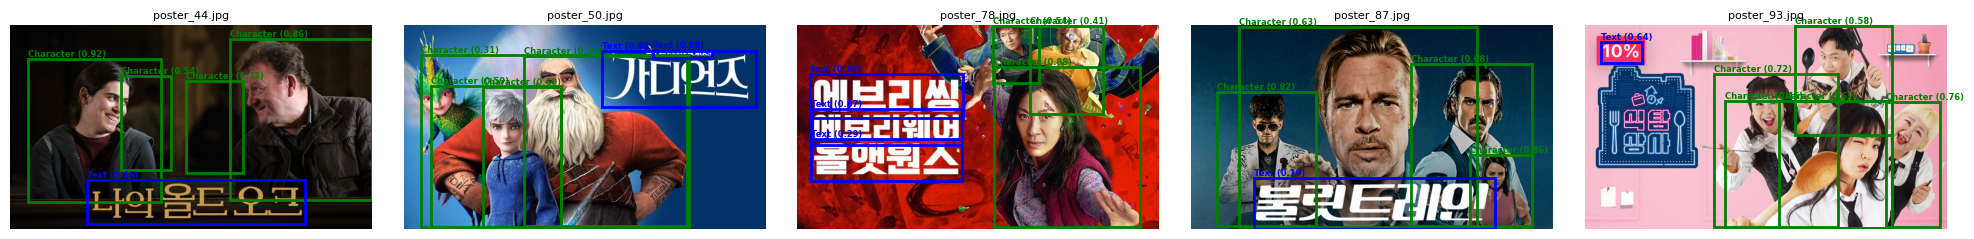

In [ ]:
# <라벨링 결과 확인>
label_csv = "labeled_posters.csv"  # 라벨링 결과 CSV 파일
image_folder = "../poster_loader/downloaded_posters"  # 이미지 폴더
labels = pd.read_csv(label_csv) # CSV 파일 로드
image_files = labels["Poster_File"].unique() # 이미지 목록 가져오기

# 5개씩 그룹화하여 표시
for i in range(0, len(image_files), 5):
    group = image_files[i:i + 5]  # 현재 그룹의 5개 이미지

    # 현재 그룹 크기에 맞게 서브플롯 생성
    fig, axes = plt.subplots(1, len(group), figsize=(20, 6))  
    axes = axes.flatten()

    for idx, image_file in enumerate(group):
        image_path = os.path.join(image_folder, image_file)

        try:
            image = Image.open(image_path)  # 이미지 로드
        except Exception as e:
            print(f"Cannot open {image_file}: {e}")
            continue

        # 현재 축 가져오기
        ax = axes[idx]
        ax.imshow(image)
        ax.axis("off")  # 축 제거
        ax.set_title(image_file, fontsize=8)

        # 현재 이미지의 라벨 필터링
        image_labels = labels[labels["Poster_File"] == image_file]

        # Bounding Box 추가
        for _, row in image_labels.iterrows():
            x1, y1, x2, y2 = int(row["X1"]), int(row["Y1"]), int(row["X2"]), int(row["Y2"])
            label_type = row["Object_Type"]
            confidence = row.get("Confidence", 1.0)  # Confidence 값이 없는 경우 기본값 1.0

            # Bounding Box 색상 설정
            color = "green" if label_type == "Character" else "blue"  # 인물은 초록색, 텍스트는 파란색

            # Bounding Box 그리기
            rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)

            # 라벨 텍스트 추가
            ax.text(x1, y1 - 5, f"{label_type} ({confidence:.2f})", color=color, fontsize=6, weight='bold')

    # 빈 축 숨기기
    for j in range(len(group), len(axes)):
        axes[j].axis("off")

    # 그리드 표시
    plt.tight_layout()
    plt.show()
    

    # 사용자 입력 대기
    user_input = input("다음페이지(Enter), 종료(ㅂ): ")
    if user_input.lower() == "ㅂ":
        break
